<h1 style="padding-left:25%;font-family:Georgia" > Food Image Classification </h1>

<h2 style="font-family:Georgia">1. Business Problem</h2>

<h3 style="font-family:Georgia">1.1 Problem Statement</h3>

<p style="font-family:Georgia;font-size:15px;">Create an automated machine learning application that can distinguish between "Food" and "Non-food" Images.</p>

<h2 style="font-family:Georgia">2. Machine Learning Problem</h2>

<h3 style="font-family:Georgia">2.1 Data Overview</h3>

<p style="font-family:Georgia;font-size:15px;">This dataset contains 68 images of "food" and 68 images of "non-food" .So it is a balanced dataset.</p>
<p style="font-family:Georgia;font-size:15px;">So Food image contains images regarding the dishes.</p>
<p style="font-family:Georgia;font-size:15px;">Non-food image contains images regarding interiors,buildings,persons.</p>
<p style="font-family:Georgia;font-size:15px;">No pictures of people cooking are contained in any of the folders.</p>
<ol style="font-family:Georgia;font-size:15px;">
    <li>There are two types of Images <ol>
                                         <li>Food.</li>
                                         <li>Non-Food.</li>
                                      </ol>
    </li>
</ol>

<h3 style="font-family:Georgia">2.2 Example Images</h3>

Food Image


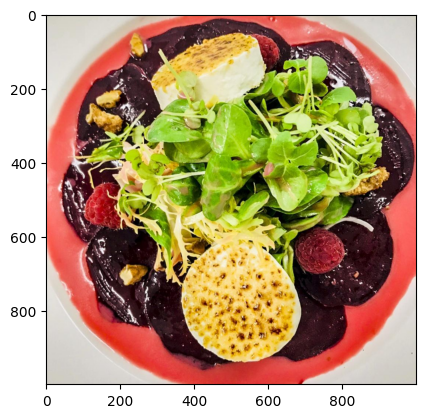

In [82]:
print("Food Image")
image_display = Image.open("dataset/food/1_  (1).jpg")
plt.imshow(image_display)

Non-Food Image


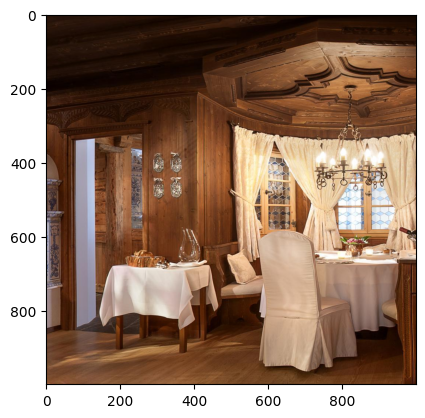

In [83]:
print("Non-Food Image")
image_display = Image.open("dataset/non_food/0_  (1).jpg")
plt.imshow(image_display)

<h2 style="font-family:Georgia">3. Mapping the real-world problem to an ML problem</h2>

<h3 style="font-family:Georgia">3.1 Type of Machine Learning Problem</h3>

<p style="font-family:Georgia;font-size:15px;">There are only two types of images Food and Non-Food. So, finally it would be a binary-classification problem.</p>

<h3 style="font-family:georgia;">3.2 Real-world/Business objectives and constraints.</h3>

<ol style="font-family:georgia;font-size:15px;">
<li>Low-latency requirement.</li>
<li> Errors can be very costly.</li>
<li> Probability of a data-point belonging to each class is needed.</li>
</ol>

<h3 style="font-family:Georgia">3.3 Performance Metric</h3>

<p style="font-family:Georgia;font-size:15px;">Metric(s): </p>
<ul style="font-family:Georgia;font-size:15px;">
    <li>Accuracy</li>
    <li>Log Loss</li>
    <li>Confusion matrix</li>
</ul>

<h3 style="font-family:Georgia">3.4 Dataset Split</h3>

<p style="font-family:Georgia;font-size:15px;">Split the dataset into three parts Train, Cross validation and Test with 64%,16%, 20% of data respectively</p>

In [84]:
#import necessary packages
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import warnings

from keras import applications
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image    

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
import scikitplot.metrics as skplot
import keras.utils as image


In [85]:
BASE_PATH = 'dataset/'
CLASS_PATH = ['food/','non_food/']

<h3 style="font-family:georgia;">4.1 Extraction Using Transfer Learning</h3>

<p style="font-family:georgia;font-size:15px;">For a normal computer, training a large neutral network with millions of images or data takes lot of computing power and is very expensive so better idea is to use a pre-trained model like VGG-16 without having to master the skills necessary to tune and train those models which have been already trained with lots of images as we can directly use the weights and architecture obtained and apply the learning on our problem statement. This method is also known as <b>Transfer learning</b>. We “transfer the learning” of the pre-trained model to our specific problem statement. So, loading the pre-trained models and using that model for prediction is relatively straightforward and described here.</p>

In [86]:
#Function to extract image features using VGG-16 Transfer Learning

def bottleneck_features(BASE_PATH,CLASS_PATH):
    
    img_width,img_height = 350,350
    target_size = (img_width,img_height)
    PATH = BASE_PATH+CLASS_PATH
    number_samples = len(list(os.listdir(PATH)))
    print("Found {} images for processing of {} class".format(number_samples,CLASS_PATH.split('/')[0]))
    data = []
    labels = []
    for img in os.listdir(PATH):
        #Storing label
        labels.append(int(img.split('.')[0].split('_')[0]))
        
        temp_img = image.load_img(PATH+img,target_size = target_size) #Loading the image
        temp_img = image.img_to_array(temp_img) #converting image to array
        data.append(temp_img)
               
    data = np.array(data)
    #Preprocessing data needed to fit for model
    data = preprocess_input(data)
    #Build VGG-16 Pre-trained Model
    model = applications.VGG16(include_top=False,weights='imagenet')
       
    bottleneck_features = model.predict(data)    
    bottleneck_features = bottleneck_features.reshape(number_samples,51200)

    print("Saving Features and Labels of {} Class".format(CLASS_PATH.split('/')[0]))

    np.save(open(CLASS_PATH.split('/')[0]+'_features.npy', 'wb'), bottleneck_features)
    np.save(open(CLASS_PATH.split('/')[0]+'_labels.npy', 'wb'), np.array(labels))

    print('*'*40)

In [87]:
bottleneck_features(BASE_PATH,CLASS_PATH[0])
bottleneck_features(BASE_PATH,CLASS_PATH[1])

Found 68 images for processing of food class
3/3 [==============================] - 14s 4s/step
Saving Features and Labels of food Class
****************************************
Found 68 images for processing of non_food class
3/3 [==============================] - 15s 4s/step
Saving Features and Labels of non_food Class
****************************************


<h3 style="font-family:georgia">4.2 Data Preparation</h3>

In [88]:
#Loading both image features of "food" and "non-food" class and labels
food_features = np.load('food_features.npy')
food_labels = np.load('food_labels.npy')
nonfood_features = np.load('non_food_features.npy')
nonfood_labels = np.load('non_food_labels.npy')

#Stacking both "food" and "non-food" features and labels
features_data = np.vstack((food_features,nonfood_features))
labels = np.hstack((food_labels,nonfood_labels))

<h3 style="font-family:georgia">4.3 Train,Cross validation,Test Split    (64:16:20)</h3>

In [89]:
print("Total number of datapoints:",features_data.shape[0])

Total number of datapoints: 136


In [90]:
#Spliting data into Train,Cross Validation,Test
train_df, X_test, train_y, y_test = train_test_split(features_data, labels, stratify=labels, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(train_df, train_y, stratify=train_y, test_size=0.2)

In [91]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 86
Number of data points in cross validation data: 22
Number of data points in test data: 28


<h2 style="font-family:georgia">5. Machine Learning Models </h2>

<h3 style="font-family:georgia;">5.1 Predicting Using a Random Model</h3>

Log loss on Cross Validation Data using Random Model 0.6613691680412283
Log loss on Test Data using Random Model 0.6729770146380917


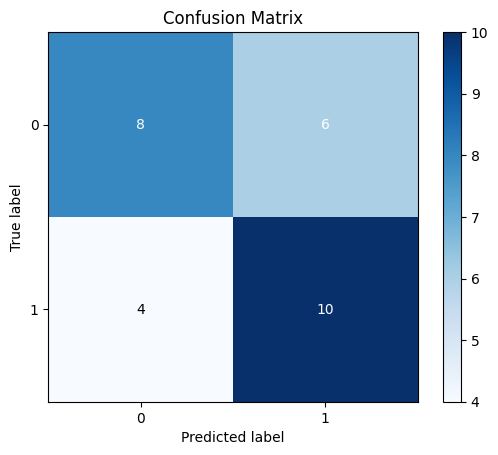

In [92]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,2))

#print(cv_predicted_y)
#print(cv_predicted_y.shape)
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ( rand_probs/sum(sum(rand_probs)) )[0]
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predict_y = np.argmax(test_predicted_y, axis=1)

skplot.plot_confusion_matrix(y_test,predict_y)
plt.show()

       -: Random Model is build mainly because of the log loss range that we need know that at what particular value 
          the model may be wrose in condition.So, Log loss is in the range[0,infinte].
       -: From the observation above that log-loss of the random model is nearly 0.66.
       -: So,whatever model is built on this data the log loss should be in between [0,0.66] for a good model 
          for consideration.

<h3 style="font-family:georgia;">5.2 Logistic Regression</h3>

<h4 style="font-family:georgia">Hyper Parameter tuning LR</h4>

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.6931471805599453
For values of alpha =  0.01 The log loss is: 0.6931471805599453
For values of alpha =  0.1 The log loss is: 0.47961248246961985
For values of alpha =  1 The log loss is: 0.23016271048587422


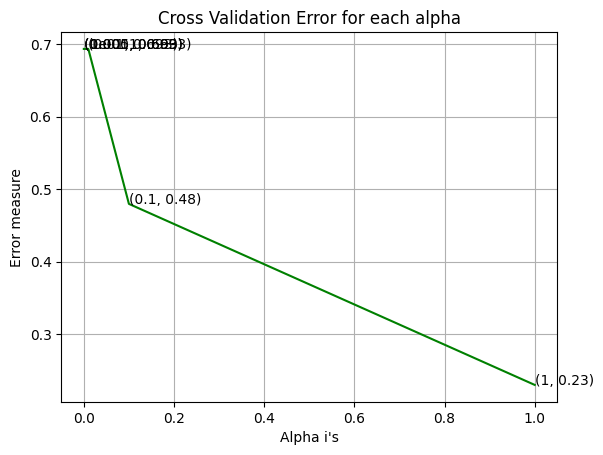

For values of best alpha =  1 The train log loss is: 0.16605633191041413
For values of best alpha =  1 The cross validation log loss is: 0.23016271048587422
For values of best alpha =  1 The test log loss is: 0.14092472761620284


In [93]:
warnings.filterwarnings("ignore")

alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4 style="font-family:georgia">Logistic Regression with best parameters</h4>

In [94]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict(X_test)
predict_prob = sig_clf.predict_proba(X_test)

In [95]:
print("Accuracy Score : {} %".format(accuracy_score(y_test,predict_y)*100))
print("Log Loss       :",log_loss(y_test, predict_prob,labels=clf.classes_, eps=1e-15))

Accuracy Score : 100.0 %
Log Loss       : 0.14092472761620284


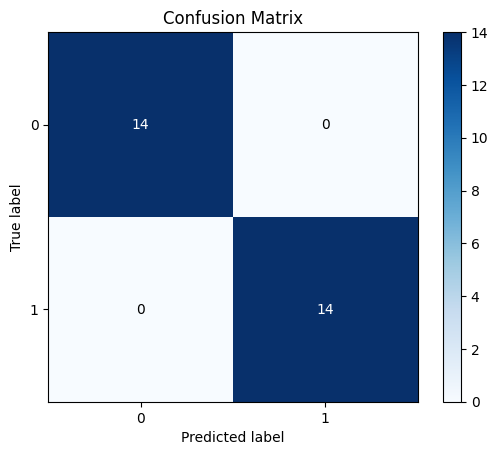

In [96]:
skplot.plot_confusion_matrix(y_test,predict_y)
plt.show()

<h3 style="font-family:georgia;">5.3 Linear SVM</h3>

<h4 style="font-family:georgia">Hyper Parameter tuning SVM</h4>

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.6931471805599453
For values of alpha =  0.01 The log loss is: 0.6931471805599453
For values of alpha =  0.1 The log loss is: 0.5647473989741129
For values of alpha =  1 The log loss is: 0.22745824367974637


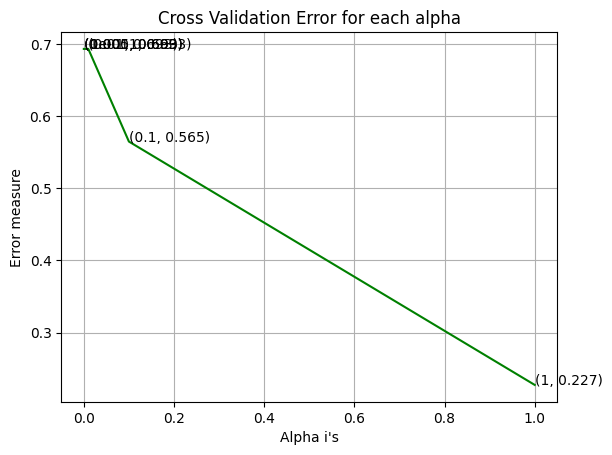

For values of best alpha =  1 The train log loss is: 0.16660296447434647
For values of best alpha =  1 The cross validation log loss is: 0.22745824367974637
For values of best alpha =  1 The test log loss is: 0.13867930330330655


In [97]:
warnings.filterwarnings("ignore")

alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4 style="font-family:georgia">SVM with best parameters</h4>

In [98]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict(X_test)
predict_prob = sig_clf.predict_proba(X_test)

In [99]:
print("Accuracy Score : {} %".format(accuracy_score(y_test,predict_y)*100))
print("Log Loss       :",log_loss(y_test, predict_prob,labels=clf.classes_, eps=1e-15))

Accuracy Score : 100.0 %
Log Loss       : 0.13867930330330655


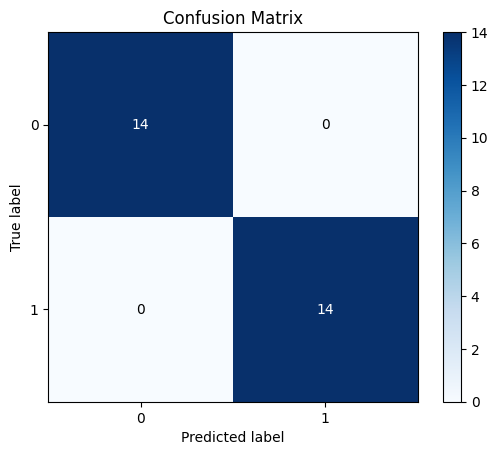

In [100]:
skplot.plot_confusion_matrix(y_test,predict_y)
plt.show()

        Observation : We are considering only LR and SVM because of large dimensionality.Both Logistic Regression 
                       and SVM Performs pretty well on the data.

<h2 style="font-family:georgia;">6. Testing Some Real World Images with Logistic Regression</h2>

In [101]:
def image_classifier(image_path):
    warnings.filterwarnings("ignore")
    
    img_width,img_height = 350,350
    target_size = (img_width,img_height)
    PATH = 'testing/'
    
    data = []
    load_img = image.load_img(PATH+image_path,target_size = target_size) #Loading the image
    load_img = image.img_to_array(load_img) #converting image to array
    data.append(load_img)
    
    preprocess_data = preprocess_input(np.array(data))
    #Build VGG-16 Pre-trained Model
    model = applications.VGG16(include_top=False,weights='imagenet')
    bottleneck_features = model.predict(preprocess_data)    
    bottleneck_features = bottleneck_features.reshape(1,51200)
    

    clf = SGDClassifier(alpha=1, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

        
    predict_prob = sig_clf.predict_proba(bottleneck_features)
    print("Food Image:",predict_prob[0][1])
    print("Non-Food Image:",predict_prob[0][0])
    predict_y = sig_clf.predict(bottleneck_features)
    if predict_y ==1:
        print("I Guess it is Food")
    else:
        print("I Guess it is Non-Food")
            
    image_display = Image.open(PATH+image_path)
    plt.imshow(image_display)

1/1 [==============================] - 0s 379ms/step
Food Image: 0.2084014267922389
Non-Food Image: 0.7915985732077611
I Guess it is Non-Food


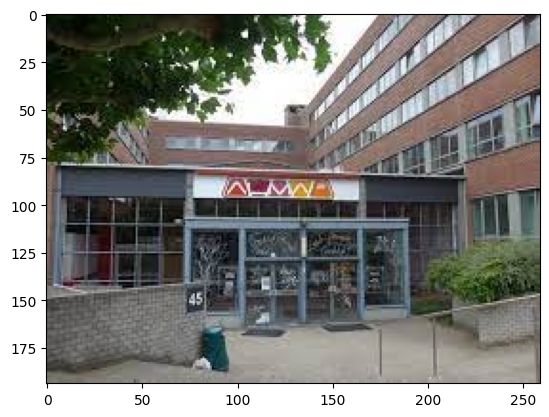

In [105]:
image_classifier('alma1.jfif')

1/1 [==============================] - 0s 354ms/step
Food Image: 0.9492448957891323
Non-Food Image: 0.05075510421086778
I Guess it is Food


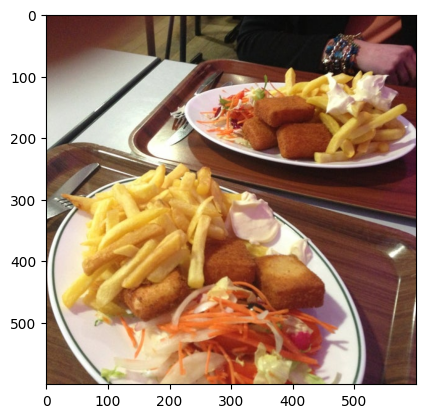

In [106]:
image_classifier('alma2.jpg')

1/1 [==============================] - 0s 351ms/step
Food Image: 0.9593801531954235
Non-Food Image: 0.04061984680457653
I Guess it is Food


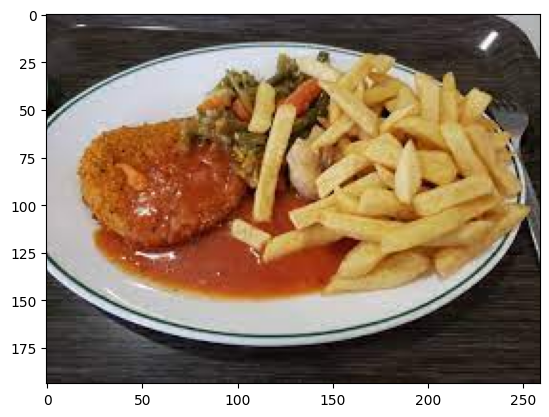

In [107]:
image_classifier('alma3.jfif')

1/1 [==============================] - 0s 371ms/step
Food Image: 0.9360138562425447
Non-Food Image: 0.06398614375745529
I Guess it is Food


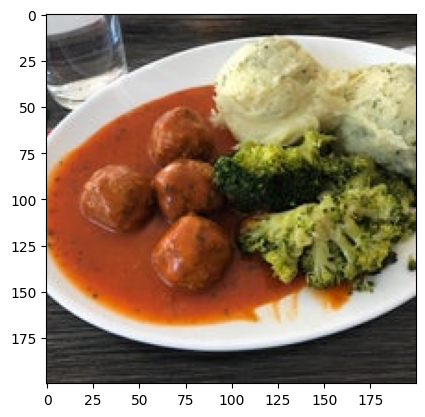

In [108]:
image_classifier('alma4.jpg')

1/1 [==============================] - 0s 370ms/step
Food Image: 0.20952802828899353
Non-Food Image: 0.7904719717110065
I Guess it is Non-Food


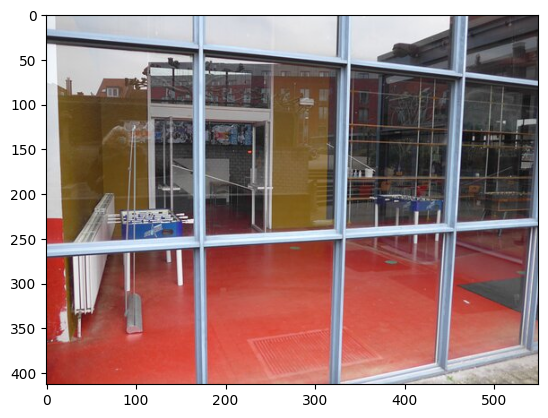

In [109]:
image_classifier('alma5.jpg')

1/1 [==============================] - 0s 368ms/step
Food Image: 0.21062428204816488
Non-Food Image: 0.7893757179518351
I Guess it is Non-Food


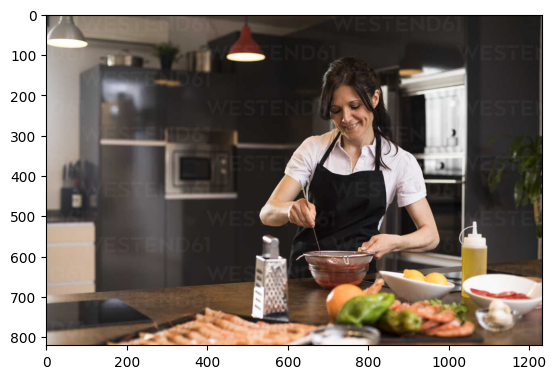

In [110]:
image_classifier('Image1.jpg')

1/1 [==============================] - 0s 368ms/step
Food Image: 0.26972930813349966
Non-Food Image: 0.7302706918665003
I Guess it is Non-Food


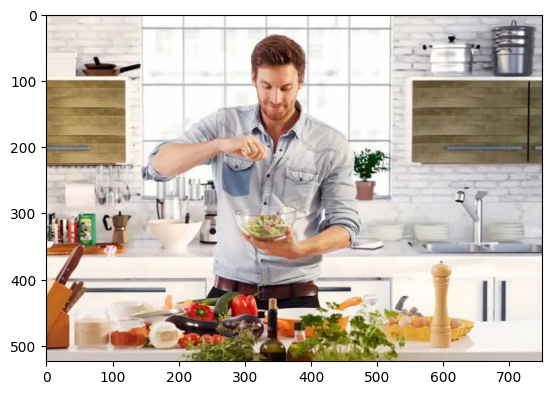

In [111]:
image_classifier('Image2.webp')

    Obervation: The model is performing well with the real world data, but it can't recognize the food when is a very small prtion in the whole image.

<p style='font-family:Georgia;font-size:15px;'><b>Procedure followed to solve this Case Study</b></p>
<ol style='font-family:Georgia;font-size:15px;'>
    <li>Importing all necessary packages</li>
    <li>Data collection</li>
    <li>Feature extraction Using CNN of Transfer Learning</li>
    <li>Data Split into Train,Validation,Test</li>
    <li>Performing Classification by building Machine Learning Models
        <ol>
            <li>Logistic Regression</li>
            <li>SVM</li>
        </ol>
    </li>
    <li>Comparing the results obtained.</li>
    <li>Testing the models with real world data.</li>
<ol>